In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
import os
from sklearn import model_selection
from sklearn import utils
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy import ndimage
from gc import collect
import matplotlib.pyplot as plt
from collections import Counter
from seaborn import heatmap


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [3]:
labels = get_labels('/kaggle/input/labelsssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 2) for number_of_class in numbers_per_class]
proportion_per_class

[0.35, 0.25, 0.23, 0.17]

In [4]:
path = '/kaggle/input/192x256xdepth/'
dirs = os.listdir(path)

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[(path+i)[-14:-4]]) for i in os.listdir(path)]

In [5]:
def balancing_batch(X, y, max_value):
    numbers_per_class = sorted(Counter(y).items())
    
    if len(numbers_per_class) == 1:
        return X[0:1], y[0:1] #return only the first image because the batch has only one class
    
    if numbers_per_class[0][1] > numbers_per_class[1][1]:
        max_per_class = numbers_per_class[1][1]
    else:
        max_per_class = numbers_per_class[0][1]
    
    if max_per_class > max_value//2:
        max_per_class = max_value//2
        
    X, y = utils.shuffle(X, y)
    new_X, new_y = [], []
    counter_class_zero = 0
    counter_class_one = 0
    for test_x, test_y in zip(X, y):
        if test_y == 0 and counter_class_zero < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_zero += 1
        elif test_y == 1 and counter_class_one < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_one += 1
    
    return np.array(new_X, dtype='float16'), np.array(new_y, dtype='float16')

In [6]:
def separate_slices(img):
    'function to separate 2d images of 3d original image'
    slices = []

    for i in range(img.shape[-2]):
        slices.append(np.array(img[:, :, i]))

    slices.append(np.mean(img, axis=-2)) #including mean of slices
        
    return slices

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y,random_state=42, train_size=0.8)

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, objective, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.objective = objective # list representing one hot encoding for choice label ([1, 0, 0, 0] for normal, [0, 0, 0, 1] for cancer ..)
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #3d-images per batch
        self.sub_batch_size = sub_batch_size #quantity of sub-images per batch will be choose to train
        self.dim_img = dim_img # tuple with width and height of image like (192, 256)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function
        
    
    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels
    
    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []
        x = x.astype('float16')
        new_images.append(x)
        
        """
        for i in range(3):
            img = x + np.random.random()/4
            img[:,:][img[:,:]>1]  = 1
            img[:,:][img[:,:]<0]  = 0
            new_images.append(img)
            
            img = x - np.random.random()/4
            img[:,:][img[:,:]>1]  = 1
            img[:,:][img[:,:]<0]  = 0
            new_images.append(img)
        """
        
        x = cv2.flip(x.astype('float32'), 1).astype('float16')
        
        """
        for i in range(3):
            img = x + np.random.random()/4
            img[:,:][img[:,:]>1]  = 1
            img[:,:][img[:,:]<0]  = 0
            new_images.append(np.expand_dims(img, -1))
            
            img = x - np.random.random()/4
            img[:,:][img[:,:]>1]  = 1
            img[:,:][img[:,:]<0]  = 0
            new_images.append(np.expand_dims(img, -1))
        """
            
        new_images.append(np.expand_dims(x, -1))

        return utils.shuffle(new_images)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    

    def __getitem__(self, index):        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        if self.training:
            X, y = balancing_batch(X, y, self.sub_batch_size)
            return np.array(X[0:self.sub_batch_size], dtype='float16'), np.array(y[0:self.sub_batch_size], dtype='uint8')
        
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = np.array(new_images, dtype='float16')
            
            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                if self.labels[ID[-14:-4]] == self.objective: #'-14:-4 represent a part of string with name of original image that slices was taken'
                    y.append(1)
                else:
                    y.append(0)
                    
        X, y = utils.shuffle(X, y)
        return X, y

In [9]:
class InceptionModule(keras.layers.Layer):
    def __init__(self, filters, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get('relu')
        
        self.conv_a    = keras.layers.Conv2D(filters[0], kernel_size=(1,1), padding='same', use_bias='false', strides=1)
        self.bn_a      = keras.layers.BatchNormalization()
        
        self.conv_b1   = keras.layers.Conv2D(filters[1], kernel_size=(1, 1), padding='same', use_bias='false', strides=1)
        self.conv_b2   = keras.layers.Conv2D(filters[2], kernel_size=(3, 4), padding='same', use_bias='false', strides=1)
        self.bn_b      = keras.layers.BatchNormalization()
        
        self.conv_c1   = keras.layers.Conv2D(filters[3], kernel_size=(1, 1), padding='same', use_bias='false', strides=1)
        self.conv_c2   = keras.layers.Conv2D(filters[4], kernel_size=(6, 8), padding='same', use_bias='false', strides=1)
        self.bn_c      = keras.layers.BatchNormalization()
        
        self.maxpool_d = keras.layers.MaxPooling2D(pool_size=(3, 4), padding='same', strides=1)
        self.conv_d    = keras.layers.Conv2D(filters[5], kernel_size=(1, 1), padding='same', use_bias='false', strides=1)
        self.bn_d      = keras.layers.BatchNormalization()
        
    def call(self, x):
        out1 = self.conv_a(x)
        out1 = self.bn_a(out1)
        out1 = self.activation(out1)
        
        out2 = self.conv_b1(x)
        out2 = self.conv_b2(out2)
        out2 = self.bn_b(out2)
        out2 = self.activation(out2)
        
        out3 = self.conv_c1(x)
        out3 = self.conv_c2(out3)
        out3 = self.bn_c(out3)
        out3 = self.activation(out3)
        
        out4 = self.maxpool_d(x)
        out4 = self.conv_d(out4)
        out4 = self.bn_d(out4)
        out4 = self.activation(out4)
        
        return tf.concat([out1, out2, out3, out4], axis=3)

def get_googlenet():
    GoogLeNet = keras.Sequential()

    GoogLeNet.add(keras.layers.Conv2D(filters=64, kernel_size=(6, 8), strides=2, padding='same', input_shape=(192, 256, 1)))
    GoogLeNet.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    GoogLeNet.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x)))
    GoogLeNet.add(keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same'))
    GoogLeNet.add(keras.layers.Conv2D(filters=192, kernel_size=(3, 4), strides=1, padding='same'))
    GoogLeNet.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x)))
    GoogLeNet.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    GoogLeNet.add(InceptionModule([64, 96, 128, 16, 32, 32]))
    GoogLeNet.add(InceptionModule([128, 128, 192, 32, 96, 64]))
    GoogLeNet.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x)))
    GoogLeNet.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    GoogLeNet.add(InceptionModule([192, 96, 208, 16, 48, 64]))
    GoogLeNet.add(InceptionModule([160, 112, 224, 24, 64, 64]))
    GoogLeNet.add(InceptionModule([128, 128, 256, 24, 64, 64]))
    GoogLeNet.add(InceptionModule([112, 144, 288, 32, 64, 64]))
    GoogLeNet.add(InceptionModule([256, 160, 320, 32, 128, 128]))
    GoogLeNet.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    GoogLeNet.add(InceptionModule([64, 96, 128, 16, 32, 32]))
    GoogLeNet.add(InceptionModule([64, 96, 128, 16, 32, 32]))
    GoogLeNet.add(keras.layers.GlobalAveragePooling2D())
    GoogLeNet.add(keras.layers.Dropout(0.4))
    GoogLeNet.add(keras.layers.Dense(1024, activation='relu'))
    GoogLeNet.add(keras.layers.Dense(1, activation='sigmoid'))
    
    return GoogLeNet

**NORMAL**

In [10]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [11]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[1, 0, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    googlenet = get_googlenet()
    
    googlenet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(googlenet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 112s 2s/step - loss: 0.7089 - AUC_1: 0.5258 - accuracy: 0.5288 - precision: 0.5343 - recall: 0.4460 - val_loss: 0.6803 - val_AUC_1: 0.5000 - val_accuracy: 0.7081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 67s 2s/step - loss: 0.6838 - AUC_1: 0.5976 - accuracy: 0.5702 - precision: 0.5855 - recall: 0.4809 - val_loss: 0.7071 - val_AUC_1: 0.5000 - val_accuracy: 0.2919 - val_precision: 0.2919 - val_recall: 1.0000 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 62s 2s/step - loss: 0.6461 - AUC_1: 0.6835 - accuracy: 0.6435 - precision: 0.6460 - recall: 0.6347 - val_loss: 0.6774 - val_AUC_1: 0.5000 - val_accuracy: 0.7081 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 67s 2s/step - loss: 0.6137 - AUC_1: 0.7320 - accuracy: 0.6594 - precision: 0.6847 - recall: 0.5

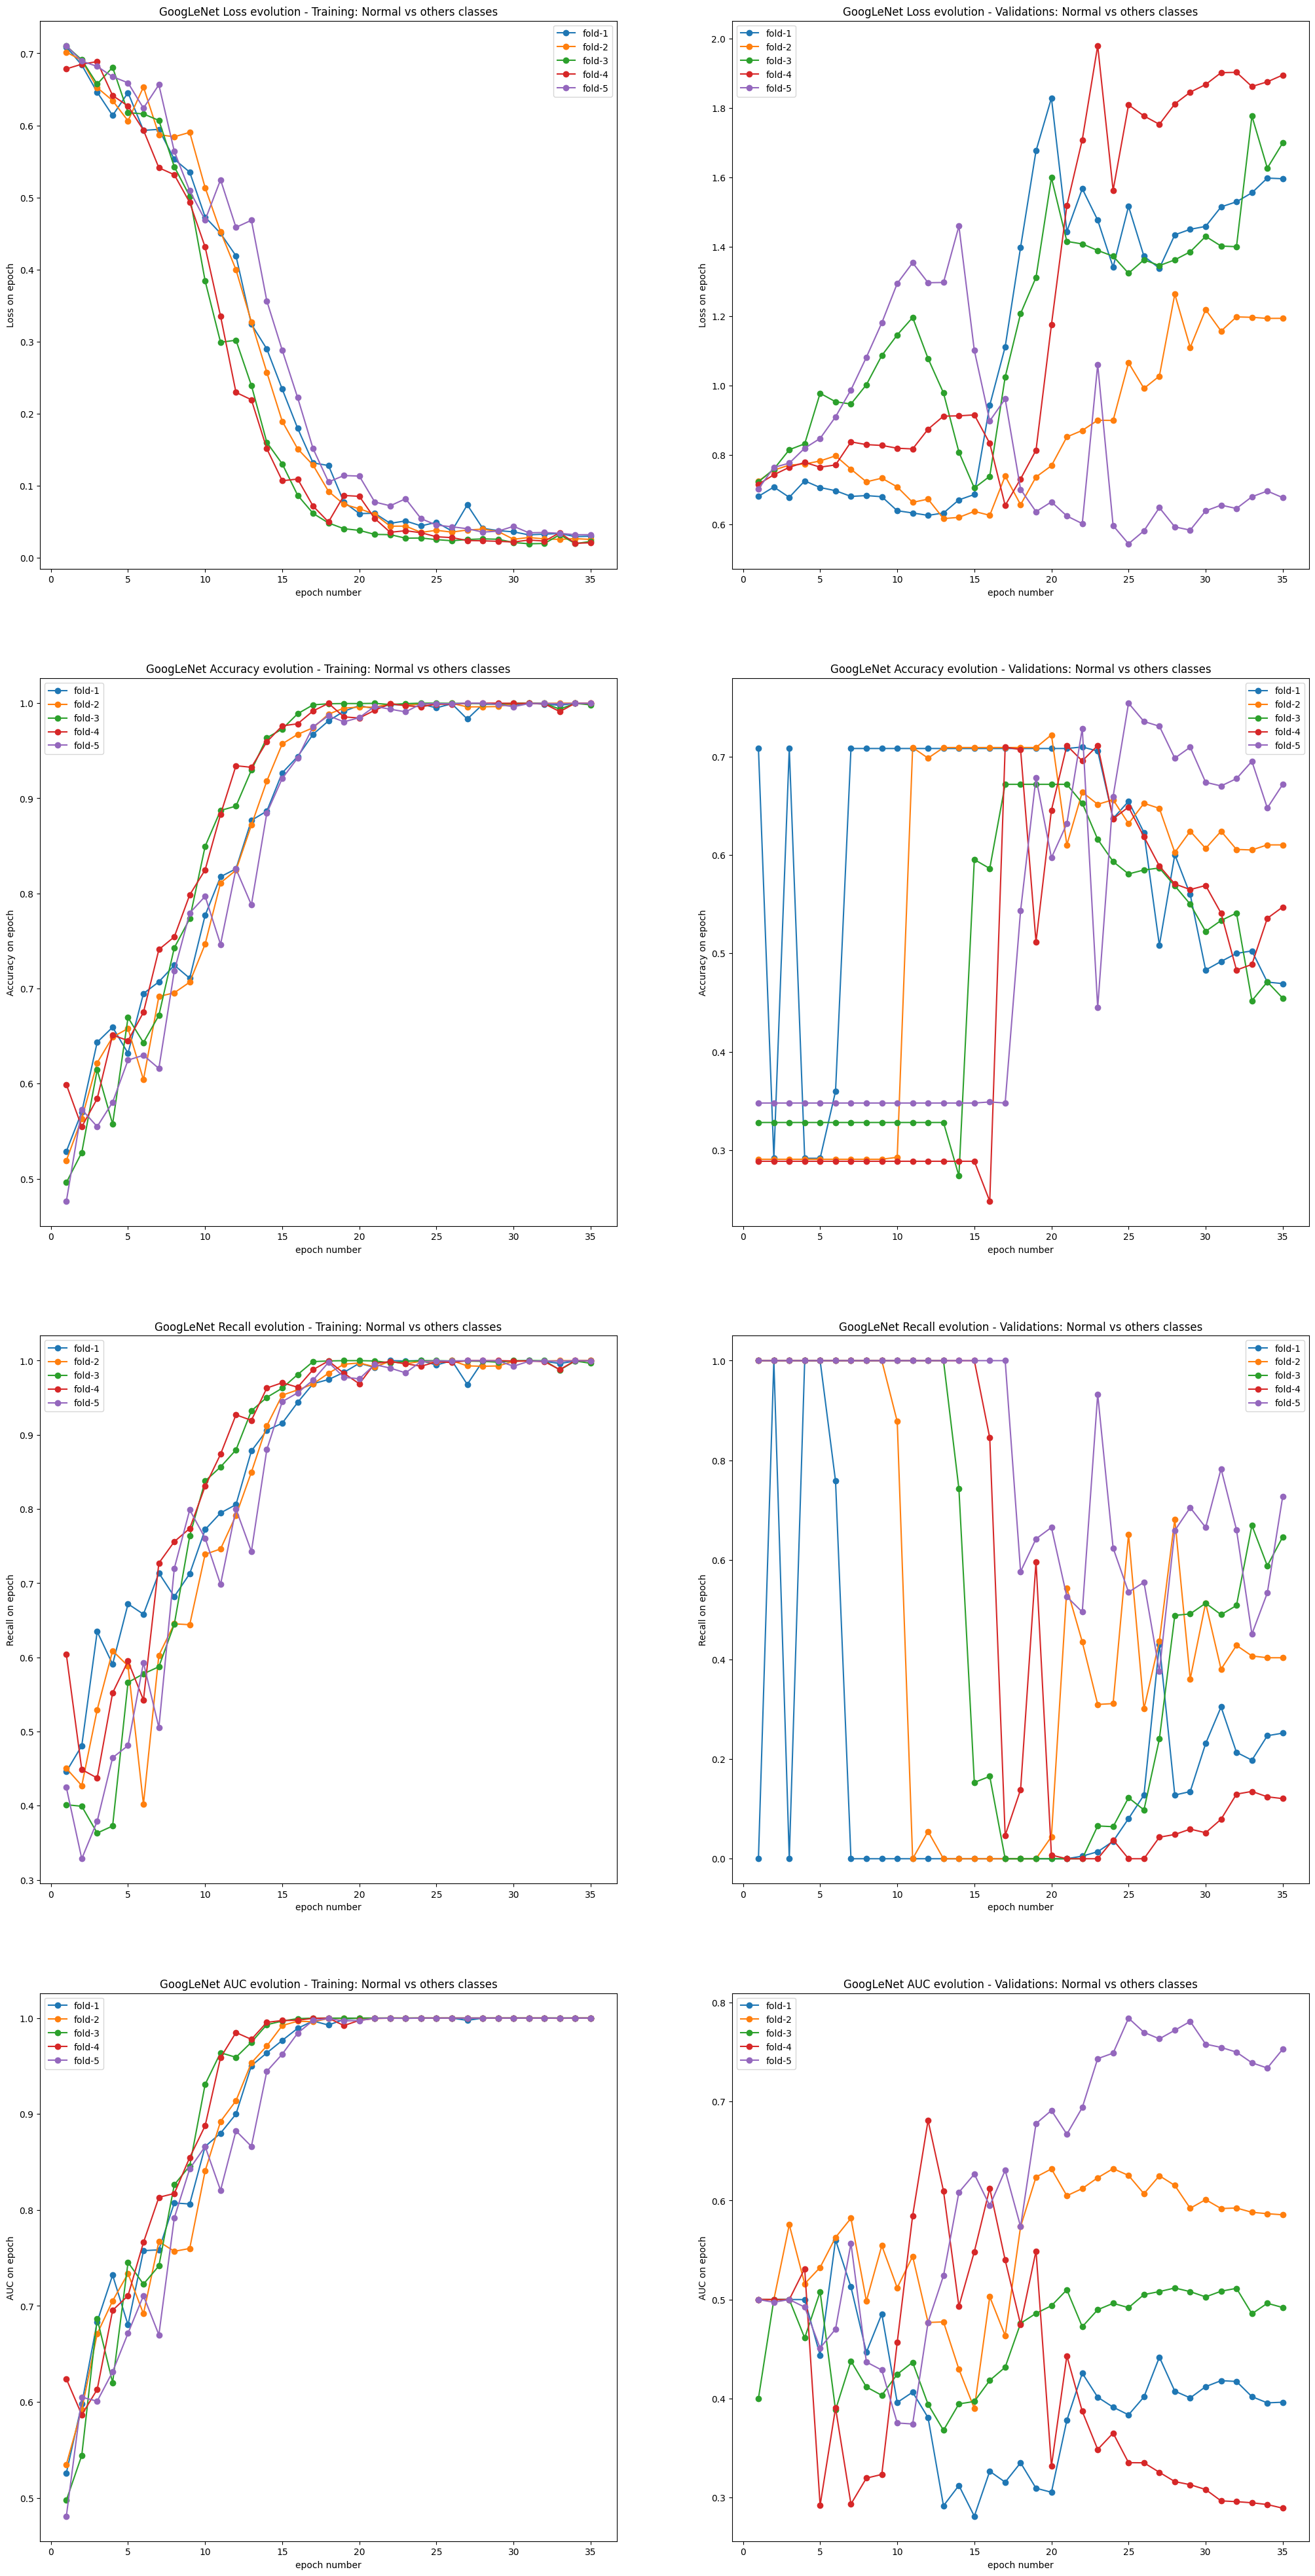

In [12]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('GoogLeNet Accuracy evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('GoogLeNet Accuracy evolution - Validations: Normal vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('GoogLeNet Recall evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('GoogLeNet Recall evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('GoogLeNet AUC evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('GoogLeNet AUC evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [13]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5601775050163269
Best Accuracy in validation: 0.7096114754676819
Best Precision in validation: 1.0
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6321919560432434
Best Accuracy in validation: 0.7219361662864685
Best Precision in validation: 1.0
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5116636753082275
Best Accuracy in validation: 0.6716943383216858
Best Precision in validation: 0.3784104287624359
Best Recall in vali

**ACTIONABLE**

In [16]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [17]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 1, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    googlenet = get_googlenet()
    
    googlenet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(googlenet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 130s 3s/step - loss: 0.7223 - AUC_1: 0.4890 - accuracy: 0.4826 - precision: 0.4580 - recall: 0.1996 - val_loss: 0.6388 - val_AUC_1: 0.5000 - val_accuracy: 0.8047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 63s 2s/step - loss: 0.6614 - AUC_1: 0.6733 - accuracy: 0.5601 - precision: 0.6424 - recall: 0.2686 - val_loss: 0.5916 - val_AUC_1: 0.6480 - val_accuracy: 0.8047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 63s 2s/step - loss: 0.6621 - AUC_1: 0.6756 - accuracy: 0.6349 - precision: 0.6701 - recall: 0.5301 - val_loss: 0.5416 - val_AUC_1: 0.5000 - val_accuracy: 0.8047 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 68s 2s/step - loss: 0.5799 - AUC_1: 0.7792 - accuracy: 0.6841 - precision: 0.7255 - rec

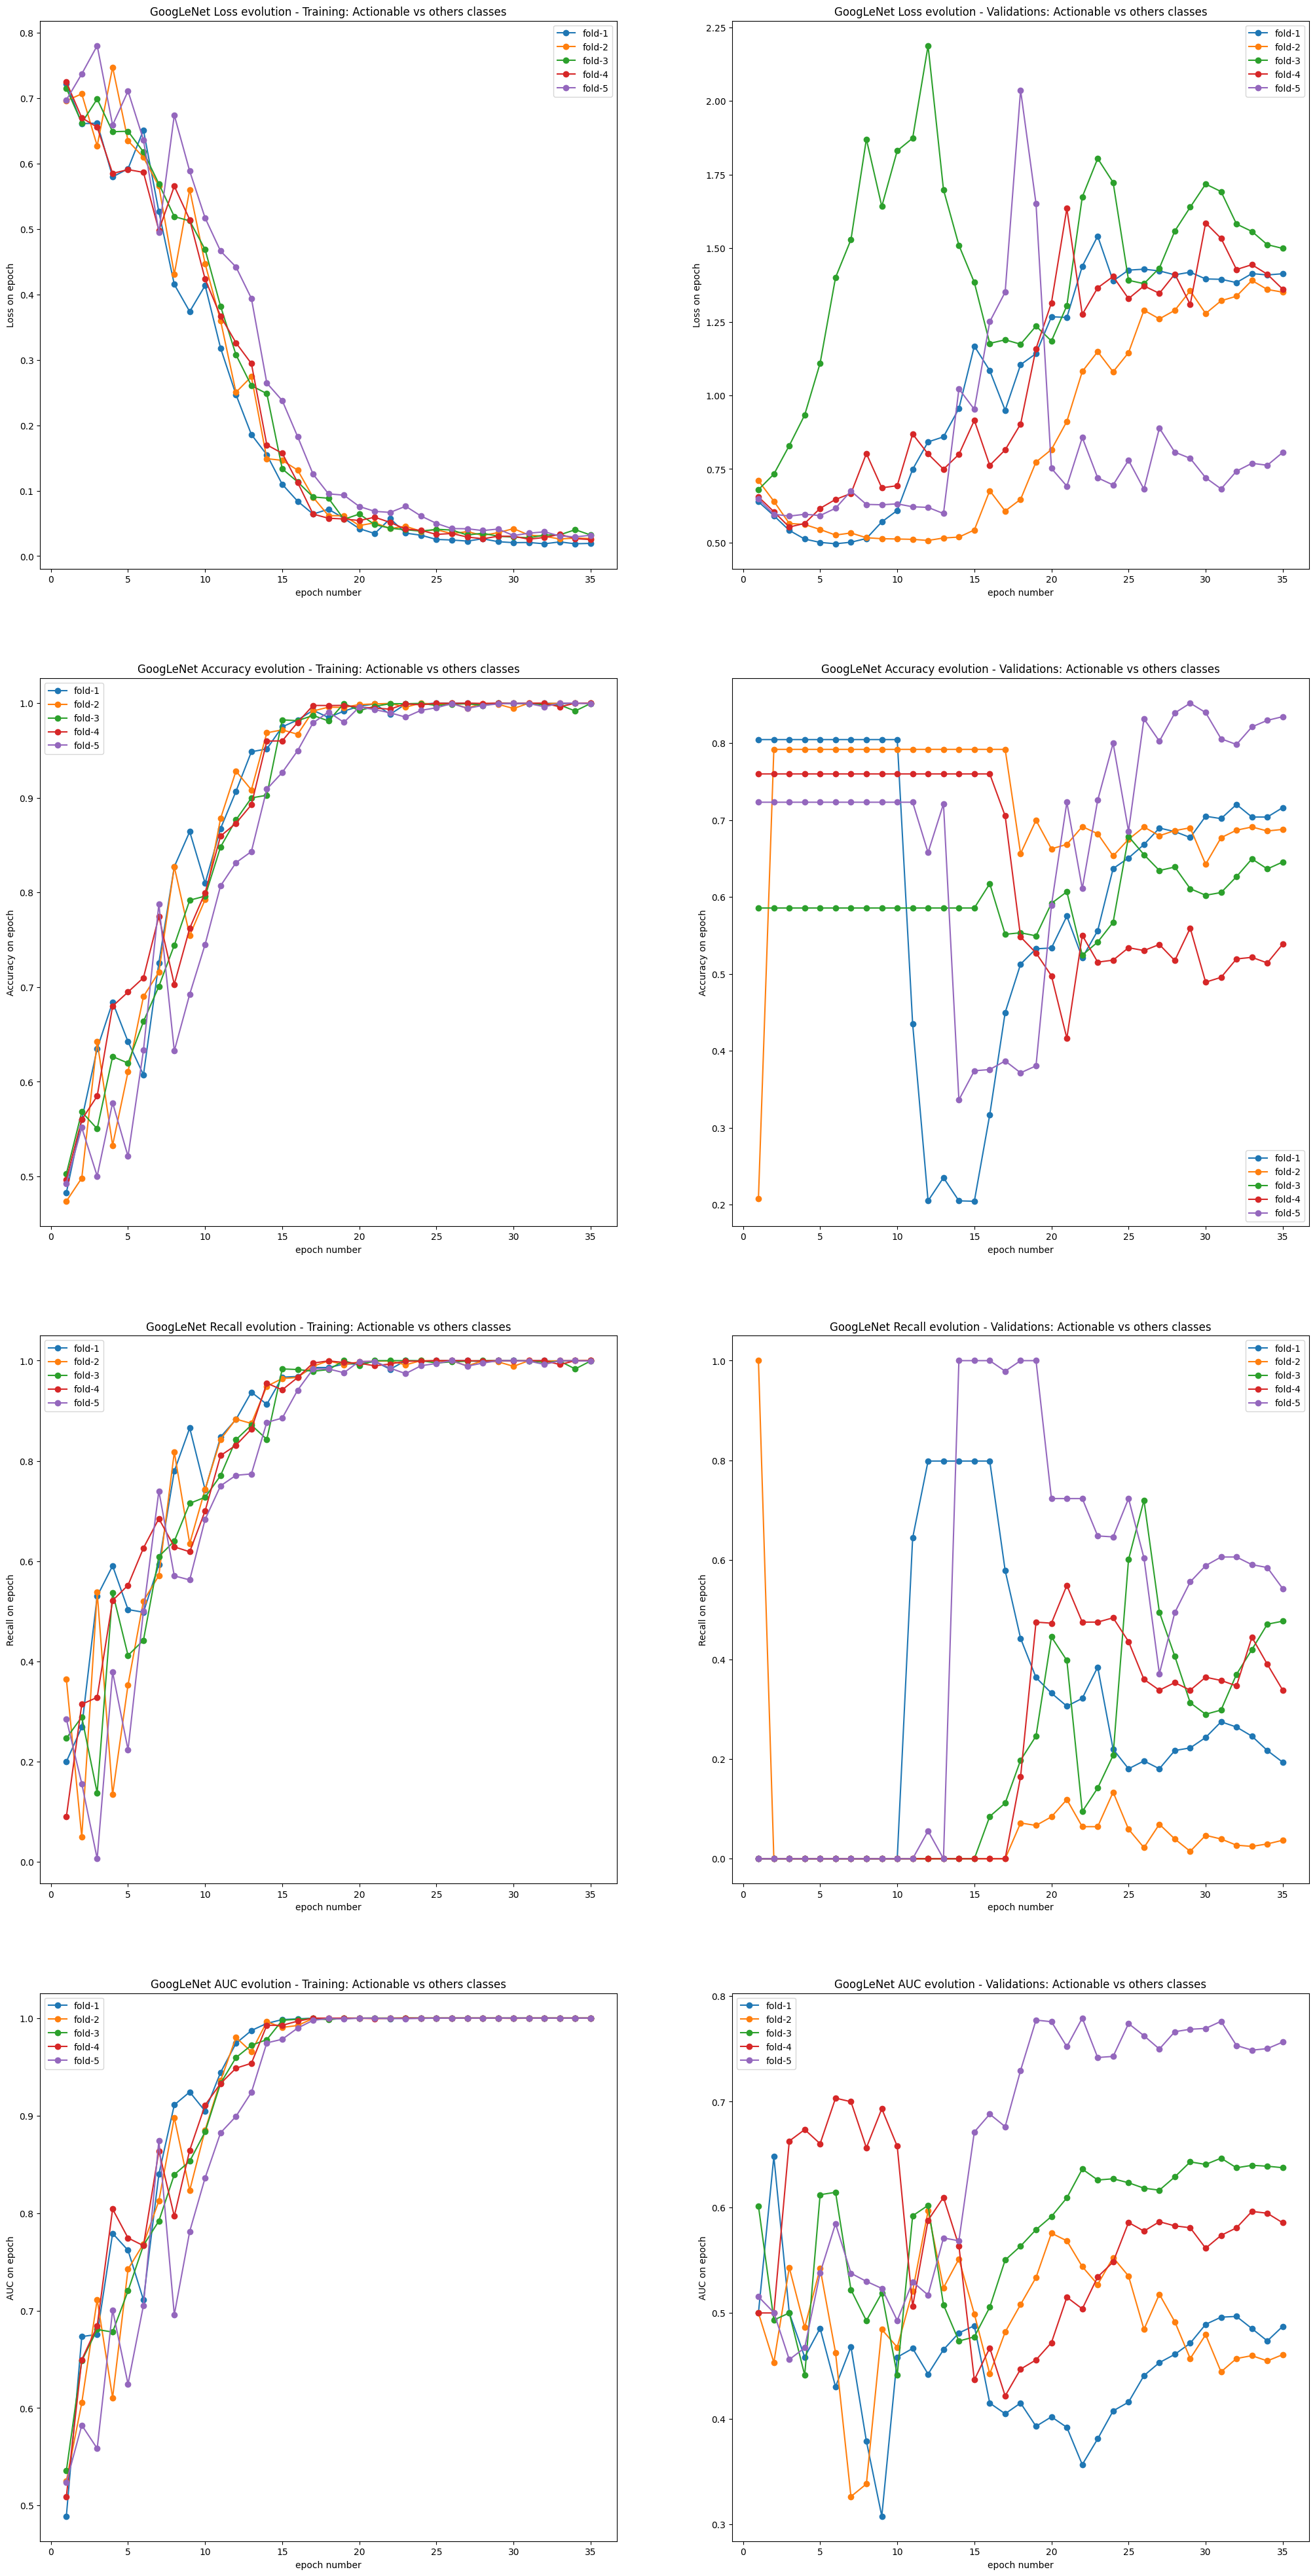

In [18]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('GoogLeNet Accuracy evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('GoogLeNet Accuracy evolution - Validations: Actionable vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('GoogLeNet Recall evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('GoogLeNet Recall evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('GoogLeNet AUC evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('GoogLeNet AUC evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [19]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6479905843734741
Best Accuracy in validation: 0.8047034740447998
Best Precision in validation: 0.2752043604850769
Best Recall in validation: 0.7984293103218079


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5965290069580078
Best Accuracy in validation: 0.7919670343399048
Best Precision in validation: 0.20803295075893402
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6465092301368713
Best Accuracy in validation: 0.6787330508232117
Best Pr

**BENIGN**

In [20]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [21]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 1, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    googlenet = get_googlenet()
    
    googlenet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(googlenet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 77s 1s/step - loss: 0.7448 - AUC_1: 0.4919 - accuracy: 0.4988 - precision: 0.4643 - recall: 0.0313 - val_loss: 0.6734 - val_AUC_1: 0.5000 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 59s 2s/step - loss: 0.7037 - AUC_1: 0.5723 - accuracy: 0.5078 - precision: 0.5329 - recall: 0.1066 - val_loss: 0.6739 - val_AUC_1: 0.5000 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 59s 2s/step - loss: 0.6971 - AUC_1: 0.6229 - accuracy: 0.5369 - precision: 0.6086 - recall: 0.1979 - val_loss: 0.7316 - val_AUC_1: 0.5114 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 64s 2s/step - loss: 0.7512 - AUC_1: 0.6956 - accuracy: 0.4970 - precision: 0.4615 - reca

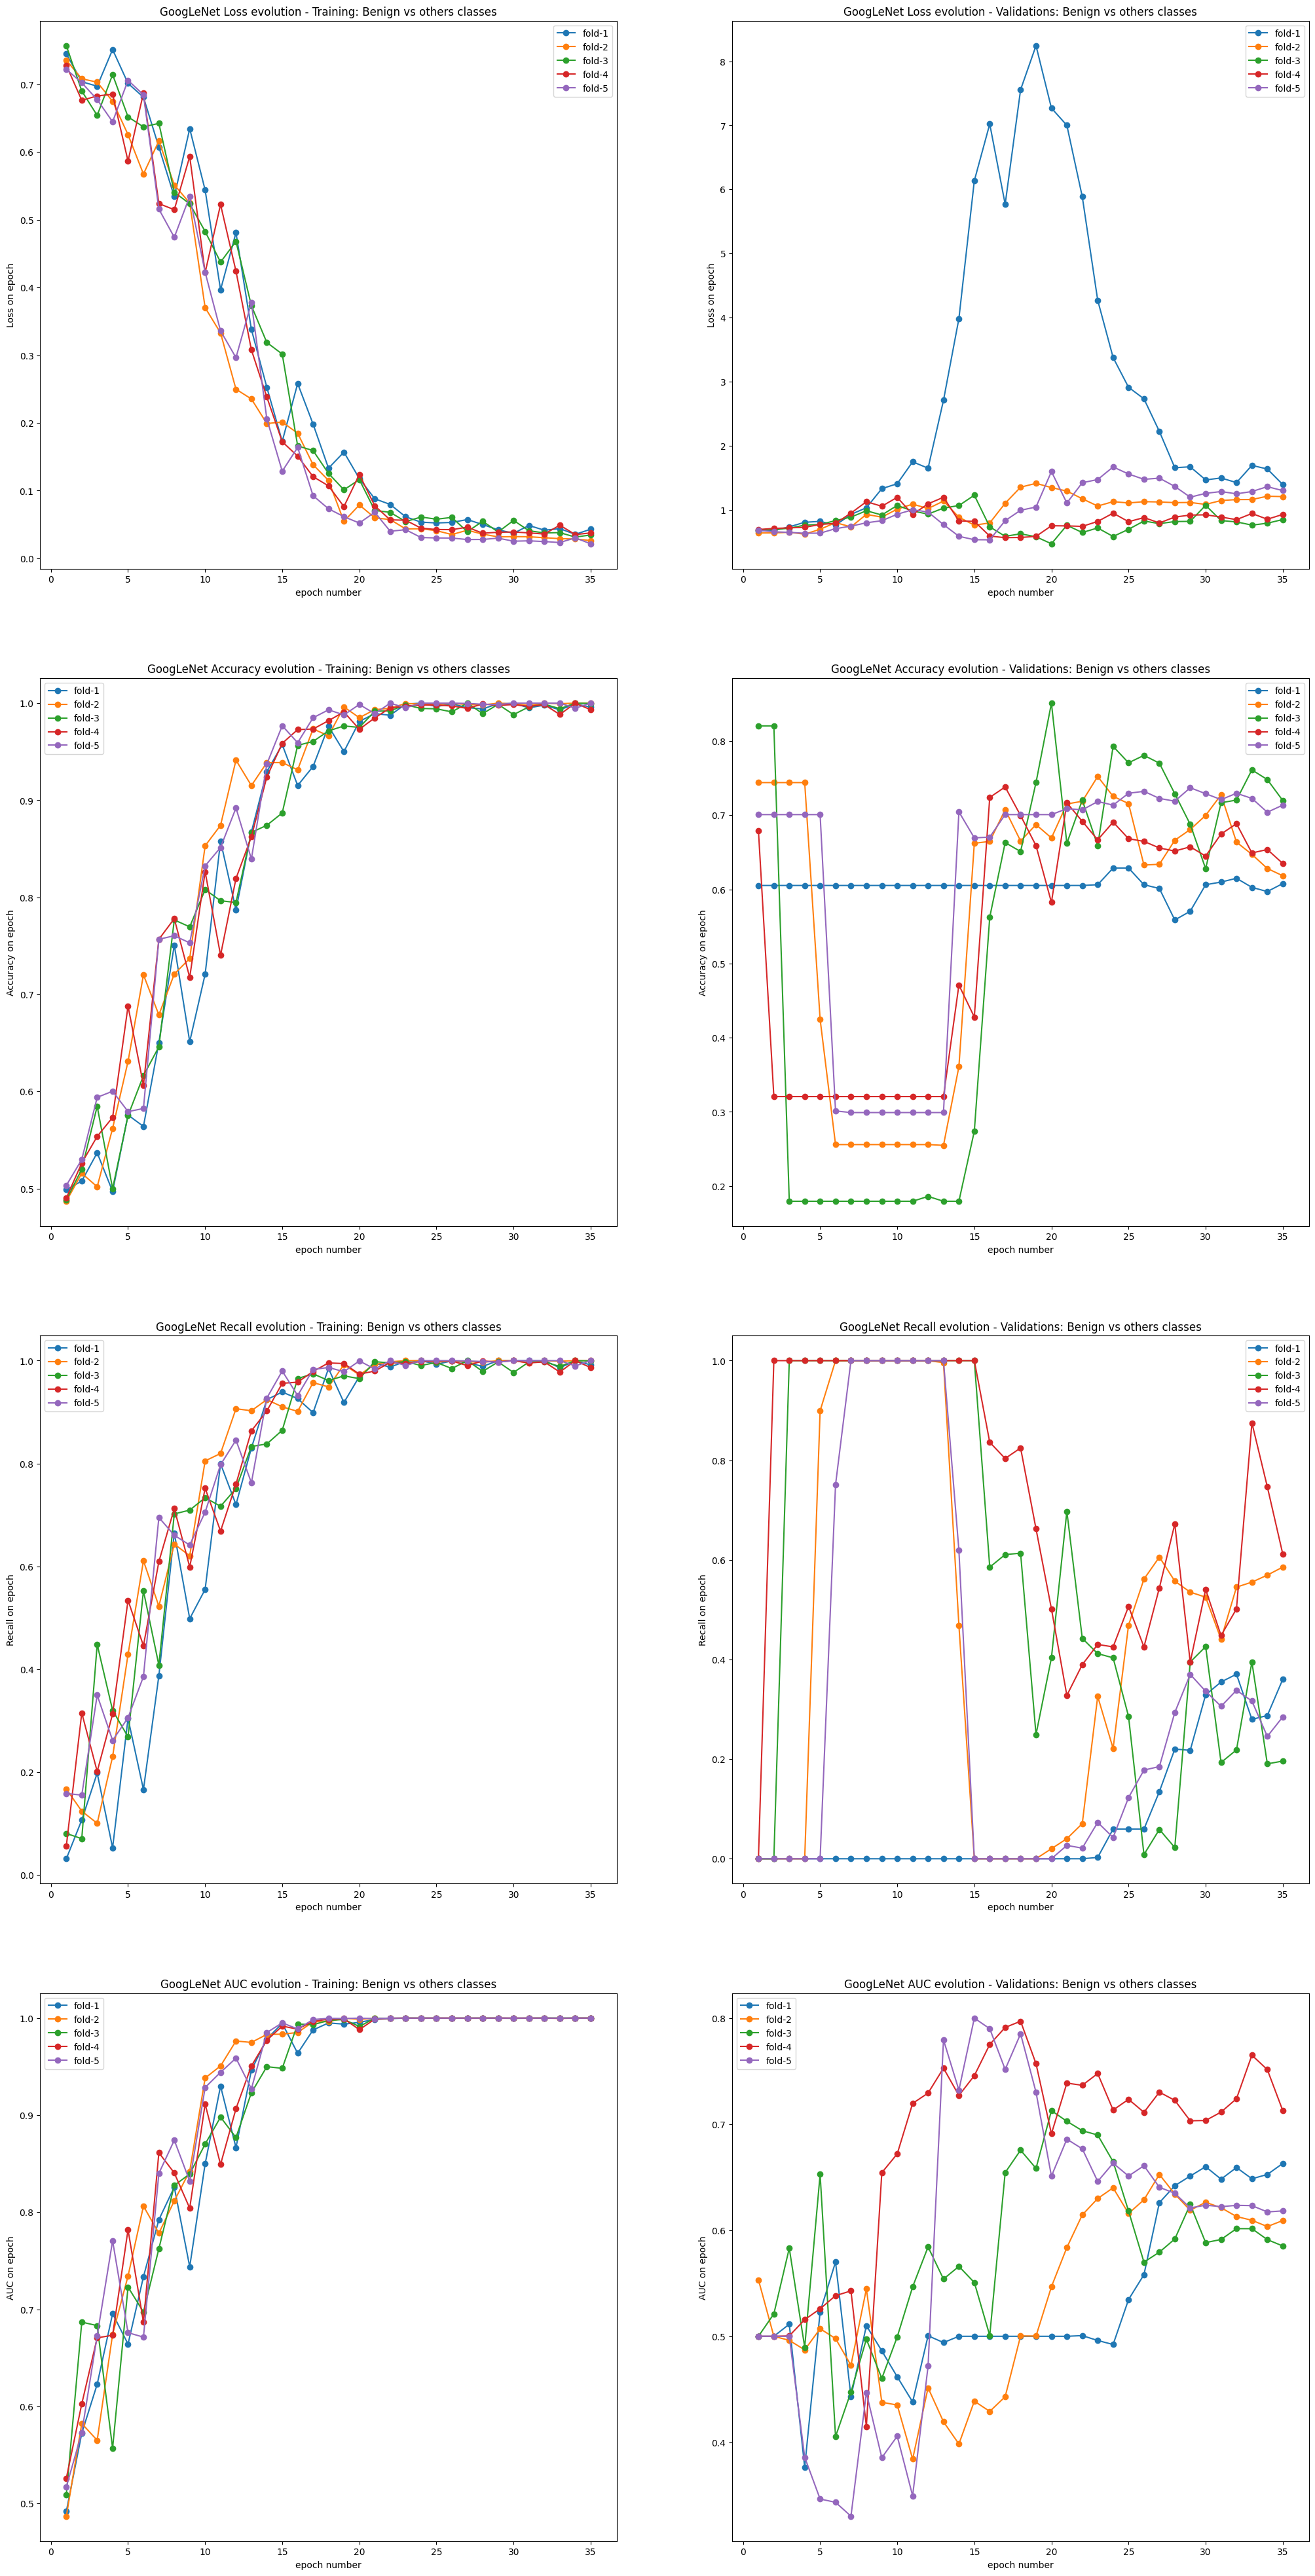

In [22]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('GoogLeNet Accuracy evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('GoogLeNet Accuracy evolution - Validations: Benign vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('GoogLeNet Recall evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('GoogLeNet Recall evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('GoogLeNet AUC evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('GoogLeNet AUC evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [23]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6630198955535889
Best Accuracy in validation: 0.6288343667984009
Best Precision in validation: 1.0
Best Recall in validation: 0.37046632170677185


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6526619791984558
Best Accuracy in validation: 0.7523171901702881
Best Precision in validation: 0.5259740352630615
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 1.0000001192092896
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.7128817439079285
Best Accuracy in validation: 0.8511815071105957
Best Pr

**CANCER**

In [24]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [25]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 0, 1],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    googlenet = get_googlenet()
    
    googlenet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(googlenet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 78s 1s/step - loss: 0.7993 - AUC_1: 0.5042 - accuracy: 0.5121 - precision: 0.5198 - recall: 0.2441 - val_loss: 0.6606 - val_AUC_1: 0.5000 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 57s 2s/step - loss: 0.7721 - AUC_1: 0.6386 - accuracy: 0.5064 - precision: 0.5849 - recall: 0.0250 - val_loss: 0.7059 - val_AUC_1: 0.5032 - val_accuracy: 0.1181 - val_precision: 0.1181 - val_recall: 1.0000 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 59s 2s/step - loss: 0.7951 - AUC_1: 0.5770 - accuracy: 0.5272 - precision: 0.7222 - recall: 0.0806 - val_loss: 0.7167 - val_AUC_1: 0.5000 - val_accuracy: 0.1181 - val_precision: 0.1181 - val_recall: 1.0000 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 63s 2s/step - loss: 0.6768 - AUC_1: 0.8039 - accuracy: 0.5577 - precision: 0.9101 - recall: 0.1239 - val

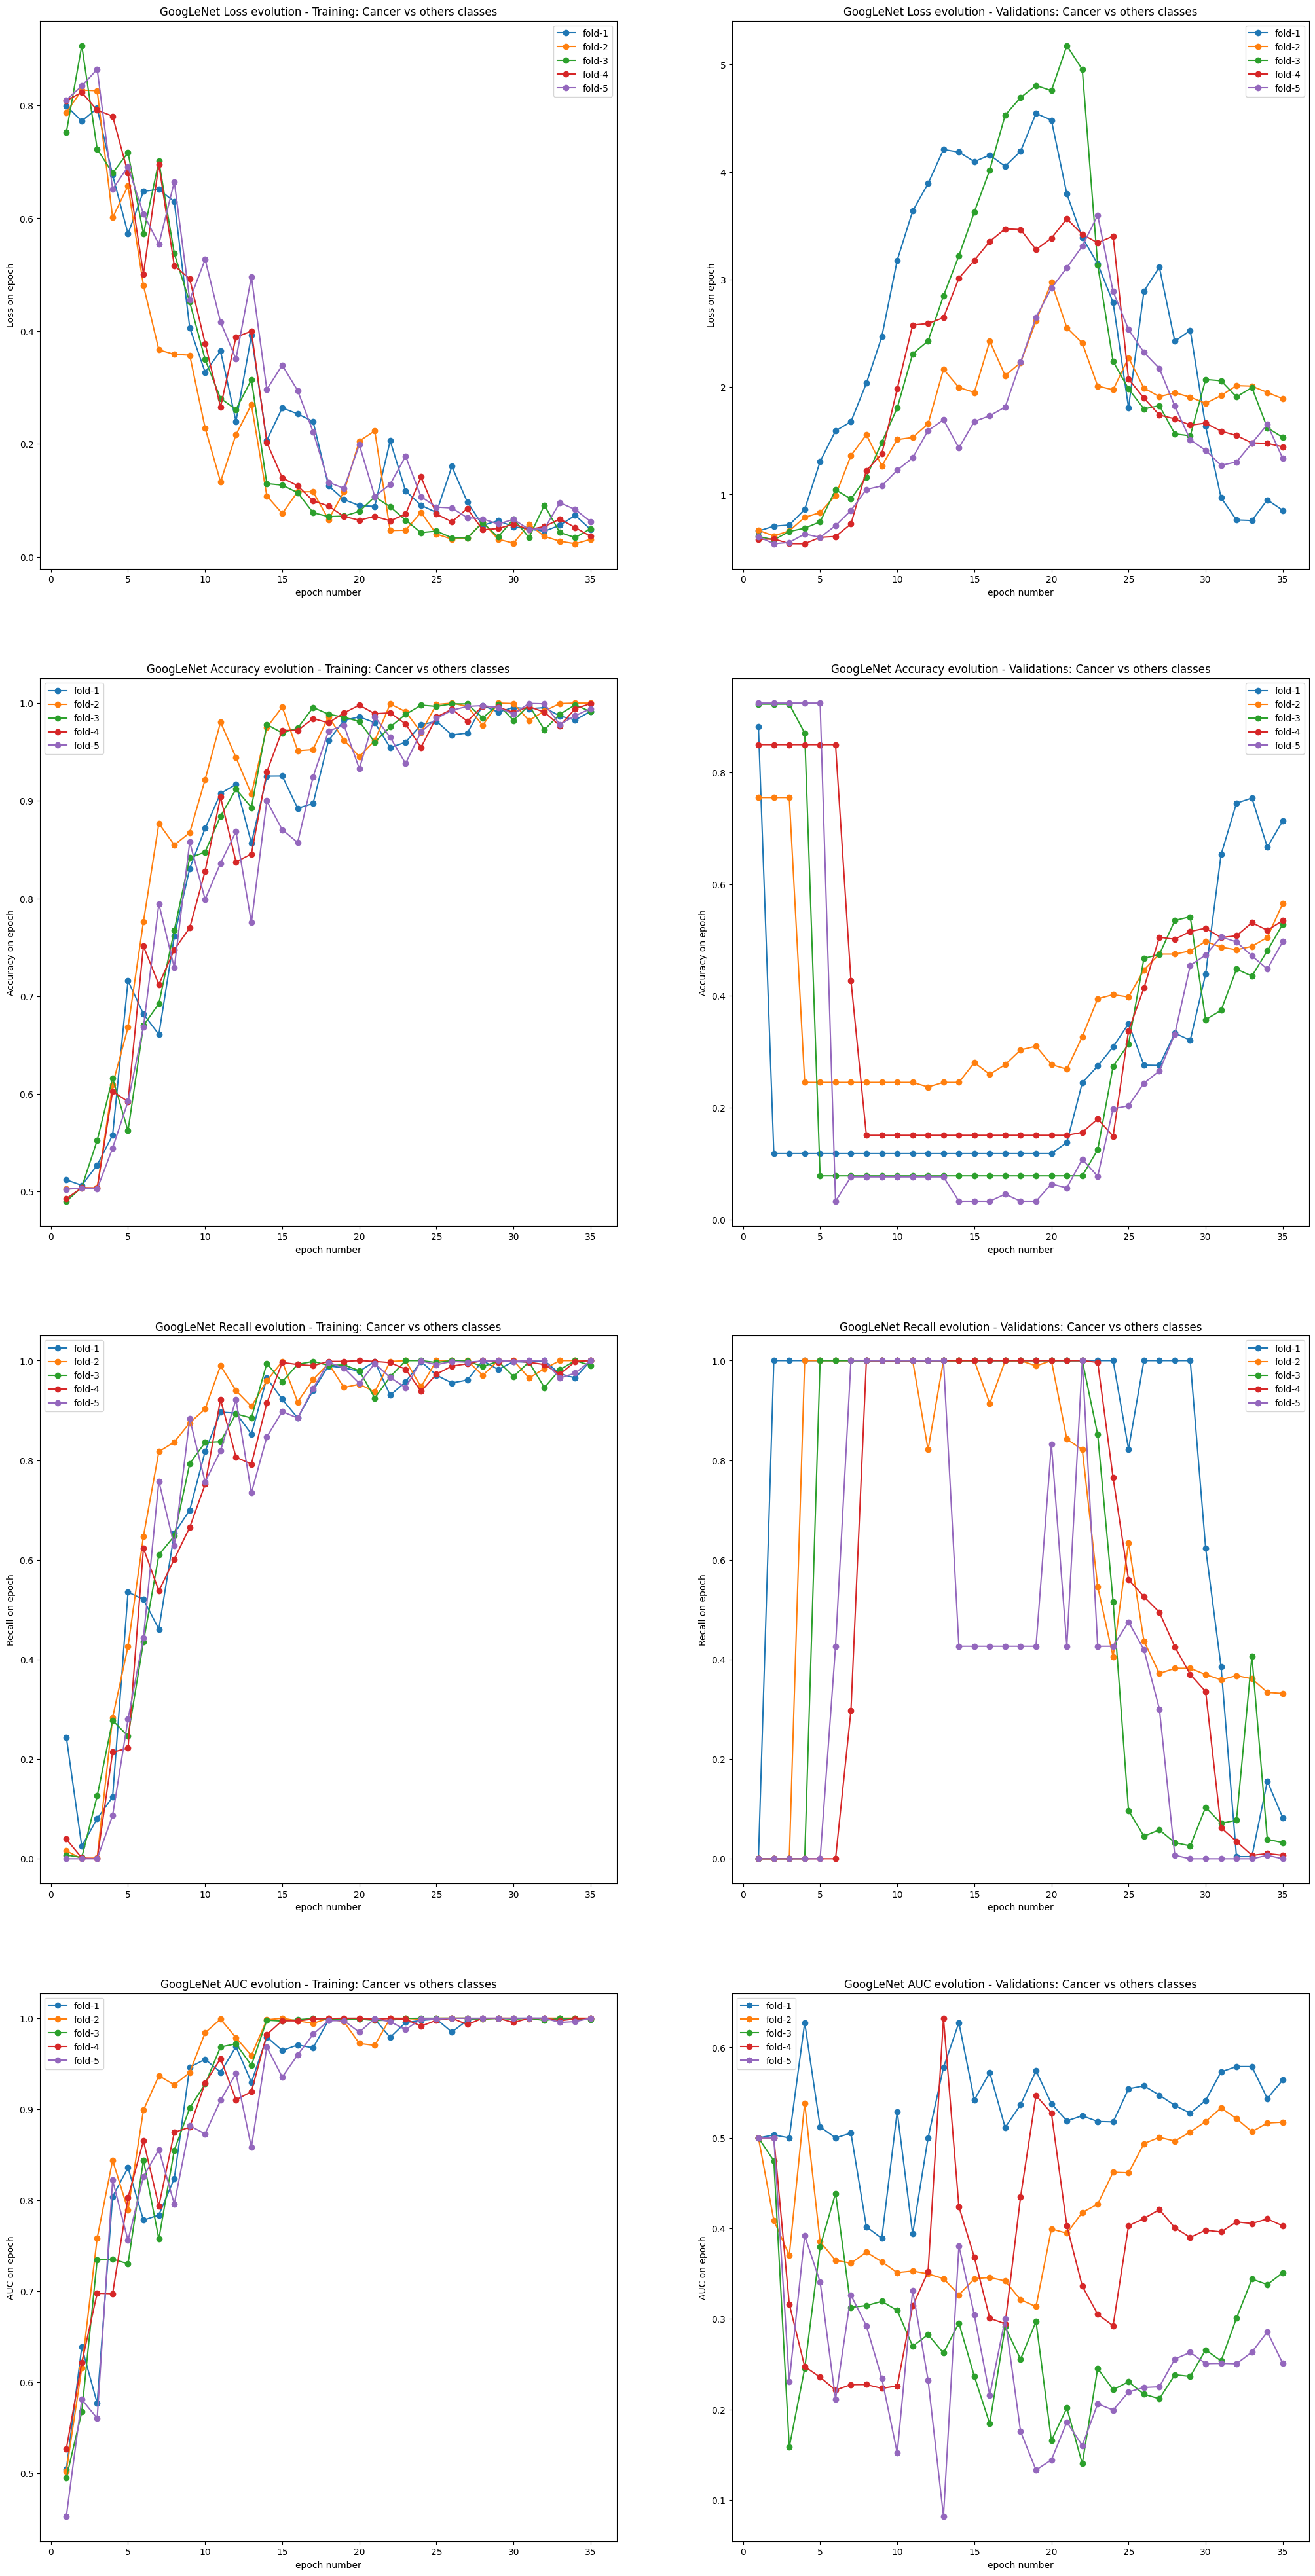

In [26]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('GoogLeNet Loss evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('GoogLeNet Accuracy evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('GoogLeNet Accuracy evolution - Validations: Cancer vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('GoogLeNet Recall evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('GoogLeNet Recall evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('GoogLeNet AUC evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('GoogLeNet AUC evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [27]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9999954700469971
Best Accuracy in train: 0.997721254825592
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6273216605186462
Best Accuracy in validation: 0.8819018602371216
Best Precision in validation: 0.15048860013484955
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 1.0
Best Accuracy in train: 1.0
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5381991863250732
Best Accuracy in validation: 0.7548918724060059
Best Precision in validation: 0.2607973515987396
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9999975562095642
Best Accuracy in train: 0.9992432594299316
Best Precision in train: 1.0
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.5
Best Accuracy in validation: 0.9220713973045349
Best Pre

**TESTS**

BENIGN VS OTHERS

In [11]:
training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
googlenet = get_googlenet()    
    
googlenet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(8e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
googlenet.load_weights('/kaggle/working/models/normal_auc5/') #start with best AUC in validations
history = googlenet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 108s 2s/step - loss: 0.3168 - AUC: 0.9440 - accuracy: 0.8890 - precision: 0.9247 - recall: 0.8468
Epoch 2/10
35/35 [==============================] - 54s 2s/step - loss: 0.2073 - AUC: 0.9766 - accuracy: 0.9308 - precision: 0.9352 - recall: 0.9257
Epoch 3/10
35/35 [==============================] - 50s 1s/step - loss: 0.1228 - AUC: 0.9953 - accuracy: 0.9615 - precision: 0.9662 - recall: 0.9563
Epoch 4/10
35/35 [==============================] - 43s 1s/step - loss: 0.1160 - AUC: 0.9945 - accuracy: 0.9674 - precision: 0.9703 - recall: 0.9642
Epoch 5/10
35/35 [==============================] - 49s 1s/step - loss: 0.0949 - AUC: 0.9976 - accuracy: 0.9766 - precision: 0.9828 - recall: 0.9702
Epoch 6/10
35/35 [==============================] - 44s 1s/step - loss: 0.0788 - AUC: 0.9985 - accuracy: 0.9884 - precision: 0.9895 - recall: 0.9873
Epoch 7/10
35/35 [==============================] - 42s 1s/step - loss: 0.0745 - AUC: 0.9992 - accuracy: 

In [12]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = googlenet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]


In [13]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 0:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[16  7]
 [13  9]]
0.5555555555555556


ACTIONABLE VS OTHERS

In [11]:
training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
googlenet = get_googlenet()    
    
googlenet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(8e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
googlenet.load_weights('/kaggle/working/models/benign_auc5/') #start with best AUC in validations
history = googlenet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 120s 2s/step - loss: 2.1475 - AUC: 0.3303 - accuracy: 0.3799 - precision: 0.2775 - recall: 0.1510
Epoch 2/10
35/35 [==============================] - 56s 2s/step - loss: 1.0841 - AUC: 0.5675 - accuracy: 0.4915 - precision: 0.4695 - recall: 0.1411
Epoch 3/10
35/35 [==============================] - 40s 1s/step - loss: 0.8095 - AUC: 0.7012 - accuracy: 0.5651 - precision: 0.6819 - recall: 0.2414
Epoch 4/10
35/35 [==============================] - 43s 1s/step - loss: 0.6809 - AUC: 0.7556 - accuracy: 0.6299 - precision: 0.7628 - recall: 0.3755
Epoch 5/10
35/35 [==============================] - 44s 1s/step - loss: 0.5937 - AUC: 0.8111 - accuracy: 0.6838 - precision: 0.8318 - recall: 0.4590
Epoch 6/10
35/35 [==============================] - 42s 1s/step - loss: 0.5615 - AUC: 0.8243 - accuracy: 0.7204 - precision: 0.8145 - recall: 0.5698
Epoch 7/10
35/35 [==============================] - 46s 1s/step - loss: 0.4901 - AUC: 0.8601 - accuracy: 

In [12]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = googlenet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]


In [13]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 1:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[14  6]
 [19  6]]
0.4444444444444444


BENIGN VS OTHERS

In [10]:
training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
googlenet = get_googlenet()    
    
googlenet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(8e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
googlenet.load_weights('/kaggle/working/models/actionable_auc5/') #start with best AUC in validations
history = googlenet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 118s 2s/step - loss: 0.4053 - AUC: 0.9190 - accuracy: 0.8482 - precision: 0.8849 - recall: 0.7998
Epoch 2/10
35/35 [==============================] - 53s 1s/step - loss: 0.3436 - AUC: 0.9379 - accuracy: 0.8627 - precision: 0.9003 - recall: 0.8152
Epoch 3/10
35/35 [==============================] - 46s 1s/step - loss: 0.3370 - AUC: 0.9451 - accuracy: 0.8584 - precision: 0.9186 - recall: 0.7861
Epoch 4/10
35/35 [==============================] - 46s 1s/step - loss: 0.1503 - AUC: 0.9913 - accuracy: 0.9527 - precision: 0.9561 - recall: 0.9489
Epoch 5/10
35/35 [==============================] - 40s 1s/step - loss: 0.1845 - AUC: 0.9852 - accuracy: 0.9259 - precision: 0.9509 - recall: 0.8977
Epoch 6/10
35/35 [==============================] - 40s 1s/step - loss: 0.1707 - AUC: 0.9873 - accuracy: 0.9334 - precision: 0.9564 - recall: 0.9079
Epoch 7/10
35/35 [==============================] - 39s 1s/step - loss: 0.1372 - AUC: 0.9904 - accuracy: 

In [11]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = googlenet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]


In [12]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 2:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[28  6]
 [ 6  5]]
0.7333333333333333


CANCER VS OTHERS

In [13]:
training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
googlenet = get_googlenet()    
    
googlenet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(8e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
googlenet.load_weights('/kaggle/working/models/cancer_auc4/') #start with best AUC in validations
history = googlenet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 74s 1s/step - loss: 0.5902 - AUC: 0.8622 - accuracy: 0.7710 - precision: 0.8116 - recall: 0.7027
Epoch 2/10
35/35 [==============================] - 37s 1s/step - loss: 0.3151 - AUC: 0.9521 - accuracy: 0.8829 - precision: 0.9175 - recall: 0.8393
Epoch 3/10
35/35 [==============================] - 38s 1s/step - loss: 0.4138 - AUC: 0.9018 - accuracy: 0.8293 - precision: 0.8393 - recall: 0.8114
Epoch 4/10
35/35 [==============================] - 43s 1s/step - loss: 0.2190 - AUC: 0.9714 - accuracy: 0.9257 - precision: 0.9071 - recall: 0.9476
Epoch 5/10
35/35 [==============================] - 41s 1s/step - loss: 0.2116 - AUC: 0.9734 - accuracy: 0.9440 - precision: 0.9375 - recall: 0.9506
Epoch 6/10
35/35 [==============================] - 38s 1s/step - loss: 0.2288 - AUC: 0.9746 - accuracy: 0.9076 - precision: 0.9137 - recall: 0.8988
Epoch 7/10
35/35 [==============================] - 38s 1s/step - loss: 0.2854 - AUC: 0.9598 - accuracy: 0

In [14]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = googlenet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]


In [15]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 3:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[16  2]
 [23  4]]
0.4444444444444444
